In [1]:
import imutils
import cv2
from matplotlib import pyplot as plt
import numpy as np
from collections import OrderedDict
import math

path = 'CapturedImage.png'



In [2]:
image = cv2.imread(path)
   



In [3]:
from scipy.spatial import distance as dist
class ColorLabeler:
    def __init__(self):
        # initialize the colors dictionary, containing the color
        # name as the key and the RGB tuple as the value
        colors = OrderedDict({
            "orange": (255, 0.1*255, 0),
            "green": (0, 255, 0),
            "yellow": (255, 255, 0),
            "black": (0, 0, 0),
            "red": (255, 0, 0),
            "blue": (0, 0, 255)})
        # allocate memory for the L*a*b* image, then initialize
        # the color names list
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []
        # loop over the colors dictionary
        for (i, (name, rgb)) in enumerate(colors.items()):
            # update the L*a*b* array and the color names list
            self.lab[i] = rgb
            self.colorNames.append(name)
        # convert the L*a*b* array from the RGB color space
        # to L*a*b*
        self.lab = cv2.cvtColor(self.lab, cv2.COLOR_RGB2LAB)
        
    def label(self, image, c):
        # construct a mask for the contour, then compute the
        # average L*a*b* value for the masked region
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        mask = cv2.erode(mask, None, iterations=2)
        mean = cv2.mean(image, mask=mask)[:3]
        # initialize the minimum distance found thus far
        minDist = (np.inf, None)
        # loop over the known L*a*b* color values
        for (i, row) in enumerate(self.lab):
            # compute the distance between the current L*a*b*
            # color value and the mean of the image
            d = dist.euclidean(row[0], mean)
            # if the distance is smaller than the current distance,
            # then update the bookkeeping variable
            if d < minDist[0]:
                minDist = (d, i)
        # return the name of the color with the smallest distance
        return self.colorNames[minDist[1]]

In [4]:
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        #print(approx)
        #print('Moin')
        delta_x = approx[0][0][0] - approx[1][0][0]
        delta_y = approx[0][0][1] - approx[1][0][1]
        theta_radians = math.atan2(delta_y, delta_x)
        #print(theta_radians)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape, math.degrees(theta_radians)

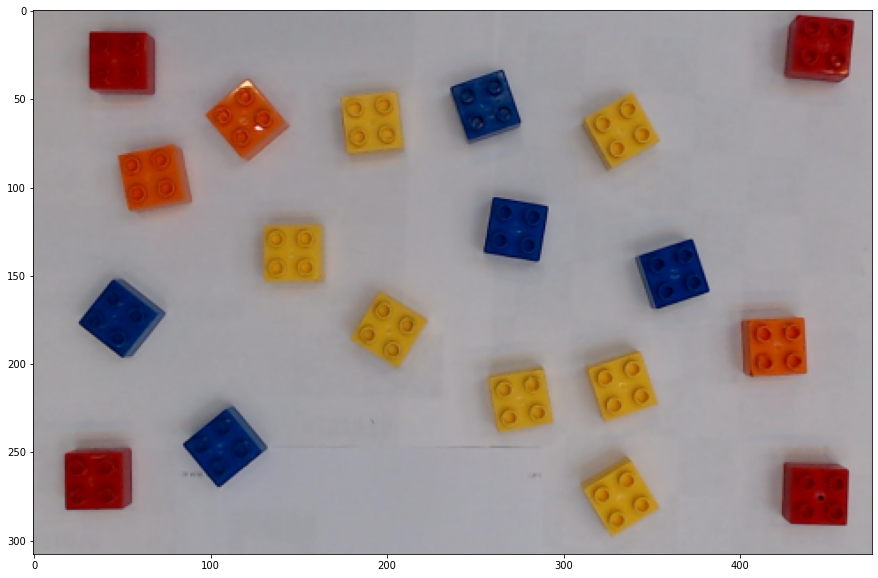

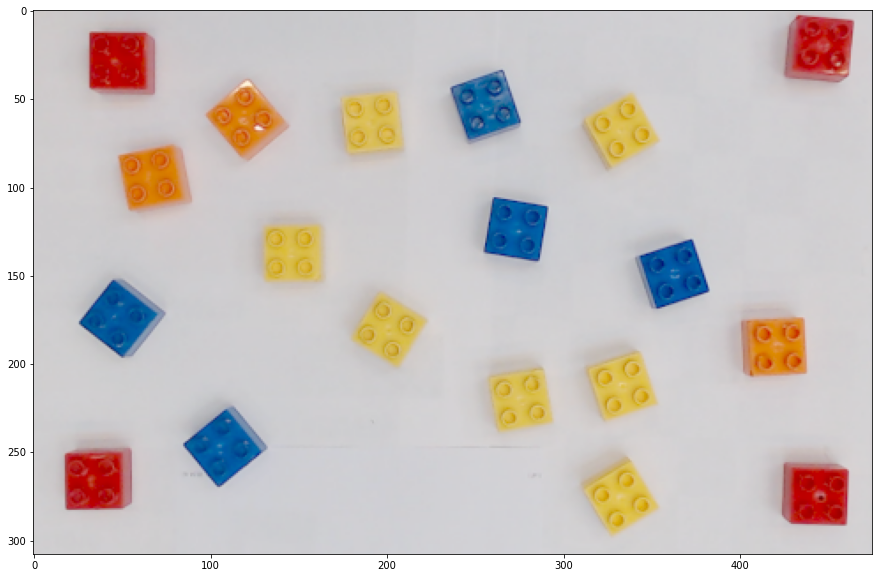

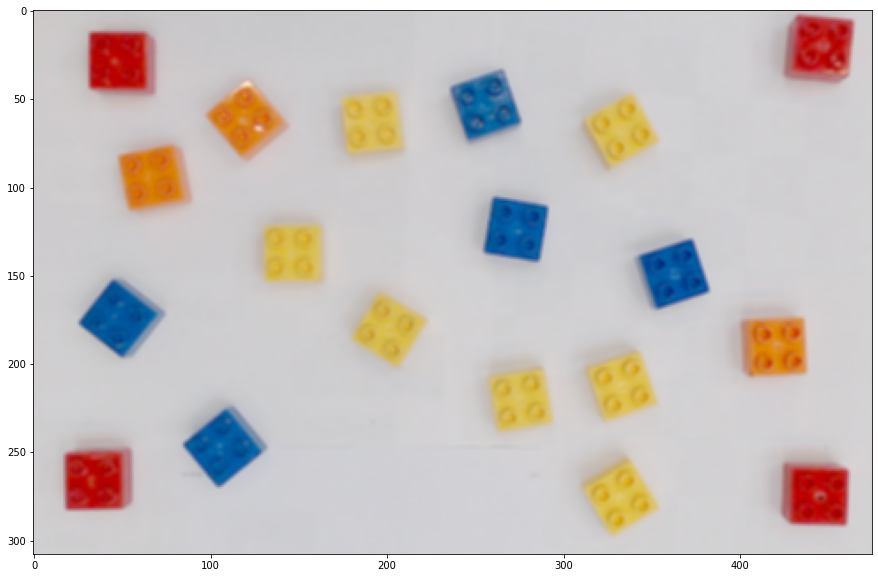

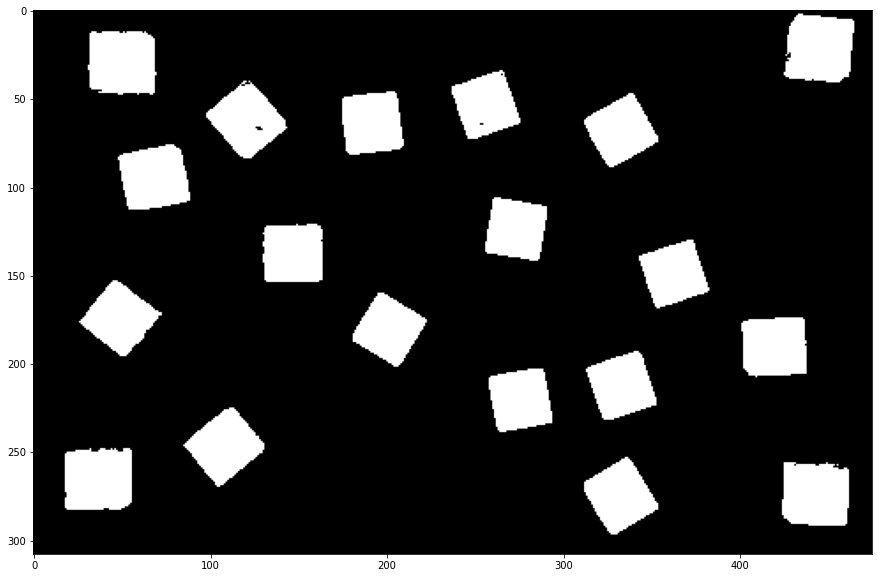

red square 442 273
yellow square 331 274
red rectangle 36 265
blue square 108 246
yellow square 275 220
yellow square 332 212
orange rectangle 419 190
yellow square 201 180
blue rectangle 48 174
blue square 362 148
yellow rectangle 146 137
blue square 273 123
orange rectangle 68 94
yellow square 332 67
yellow square 191 63
orange square 120 61
black square 255 53
red square 50 29
red rectangle 444 21


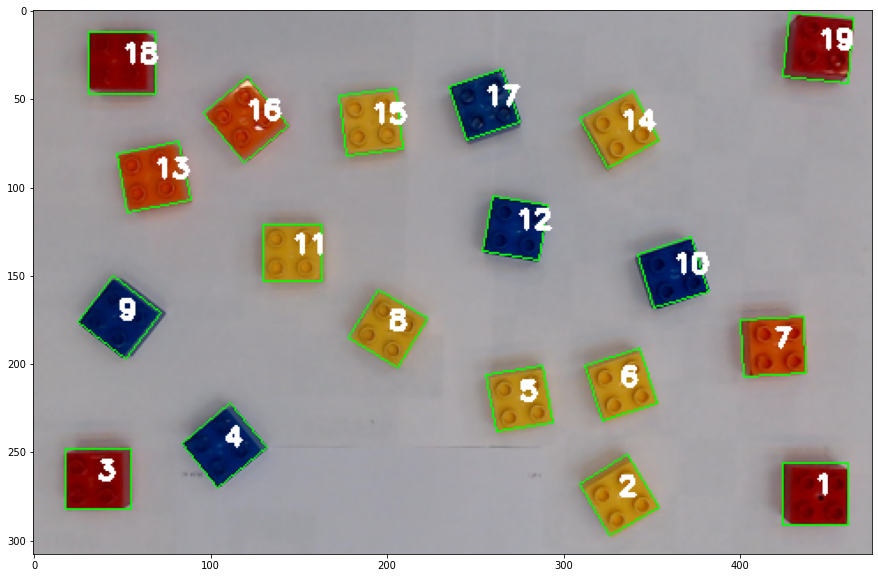

In [5]:
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
plt.show()
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)
#resized = imutils.resize(image, width=300)
#ratio = image.shape[0] / float(resized.shape[0])
resized = adjust_gamma(image, gamma=2.2)
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
cv2.imwrite('1_gamma_mapped.png',cv2.cvtColor(showim, cv2.COLOR_BGR2RGB))
plt.show()
blur = cv2.GaussianBlur(resized,(3,3),cv2.BORDER_REFLECT)
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
cv2.imwrite('2_blurred.png',cv2.cvtColor(showim, cv2.COLOR_BGR2RGB))
plt.show()
lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
img_hsv=cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
img_gray=cv2.cvtColor(img_hsv, cv2.COLOR_BGR2GRAY)
ret, img_tresh = cv2.threshold(img_gray, 100, 255,cv2.THRESH_BINARY)
plt.figure(figsize=(20,10))
showim = cv2.cvtColor(img_tresh, cv2.COLOR_BGR2RGB)
plt.imshow(showim)
cv2.imwrite('3_colorspace_conv_and_thresh.png',cv2.cvtColor(showim, cv2.COLOR_BGR2RGB))
plt.show()
arr_cnt = cv2.findContours(img_tresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(arr_cnt)
sd = ShapeDetector()
cl = ColorLabeler()
i=1
# loop over the contours
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] == 0:
        continue
    cX = int((M["m10"] / M["m00"]))# * ratio)
    cY = int((M["m01"] / M["m00"]))# * ratio)
    shape, rotation = sd.detect(c)
    color = cl.label(lab, c)
    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    #c *= ratio
    c = c.astype("int")
    print(color,shape,cX,cY)
    #print(cv2.minAreaRect(c))
    #cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    box = cv2.boxPoints(cv2.minAreaRect(c))
    box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
    cv2.drawContours(image, [box], 0, (0, 255, 0))
    cv2.putText(image,str(i), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    i+=1
plt.figure(figsize=(20,10))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
cv2.imwrite('4_detected.png',cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
"""
For homography 
↓↓↓↓uv coordinates↓↓↓↓
red square 443 273
red rectangle 36 264
red rectangle 49 29
red rectangle 445 20

↓↓↓↓world coordinates(using robot)↓↓↓↓
x -283.0 y -183.0
x -449.8 y -344.0
x -161.5 y -628.7
x 14 y -442.5"""

'\nFor homography \n↓↓↓↓uv coordinates↓↓↓↓\nred square 443 273\nred rectangle 36 264\nred rectangle 49 29\nred rectangle 445 20\n\n↓↓↓↓world coordinates(using robot)↓↓↓↓\nx -283.0 y -183.0\nx -449.8 y -344.0\nx -161.5 y -628.7\nx 14 y -442.5'

In [7]:
# to calculate the transformation matrix
input_pts = np.float32([[36, 264],[443, 273],[445, 20],[49, 29]])
output_pts = np.float32([[-449.8, -344.0],[-161.5, -628.7],[14, -442.5],[-283.0, -183.0]])


# Compute the perspective transform M
H = np.float32(cv2.getPerspectiveTransform(input_pts,output_pts))
print('Homography Matrix: \n', H)

Homography Matrix: 
 [[ 7.3150480e-01 -6.6768253e-01 -2.9856863e+02]
 [-6.4099371e-01 -7.1885395e-01 -1.3015460e+02]
 [-6.4532804e-05 -2.1253638e-06  1.0000000e+00]]


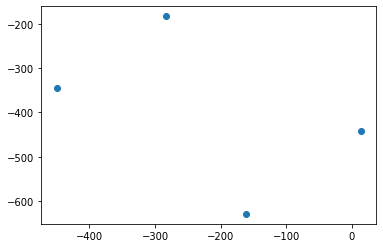

In [8]:
transform_points = input_pts.reshape(-1,1,2).astype(np.float32)

#apply homography transfrom
cartesian_points = cv2.perspectiveTransform(transform_points, H)
reduced_cartesian_points = np.squeeze(cartesian_points, axis=1)

#plot 2d cartesian points (birds eye view)
plt.scatter(reduced_cartesian_points[:,0], reduced_cartesian_points[:,1])

In [9]:
"""For printing world coordinates to validate on robot"""""
image = cv2.imread(path)
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])
resized = adjust_gamma(resized, gamma=2.6)
blur = cv2.GaussianBlur(resized,(5,5),cv2.BORDER_REFLECT)
lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
img_hsv=cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
img_gray=cv2.cvtColor(img_hsv, cv2.COLOR_BGR2GRAY)
ret, img_tresh = cv2.threshold(img_gray, 100, 255,cv2.THRESH_BINARY)
arr_cnt = cv2.findContours(img_tresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(arr_cnt)
sd = ShapeDetector()
cl = ColorLabeler()

# loop over the contours
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] == 0:
        continue
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape, rotation = sd.detect(c)
    color = cl.label(lab, c)
    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    
    world_coords = np.squeeze(cv2.perspectiveTransform(np.float32([cX,cY]).reshape(-1,1,2).astype(np.float32), H), axis=1)[0]
    print(color, shape,cX,cY, rotation)
    print('world coodinates: ', world_coords[0], world_coords[1])


red square 443 273 -86.98721249581666
world coodinates:  -161.50002 -628.7
yellow square 332 274 -28.072486935852957
world coodinates:  -244.02435 -552.08026
red square 36 264 -2.7263109939062655
world coodinates:  -449.8 -344.0
blue square 107 246 -35.21759296819271
world coodinates:  -387.42526 -378.38962
yellow square 275 219 -9.462322208025617
world coodinates:  -248.14653 -472.46133
yellow square 333 212 -15.524110996754258
world coodinates:  -200.93474 -507.12897
orange rectangle 420 190 -98.9726266148964
world coodinates:  -121.53956 -551.114
yellow square 201 180 -60.64224645720873
world coodinates:  -275.39658 -393.64465
blue rectangle 48 173 -51.34019174590991
world coodinates:  -380.28326 -286.27606
blue square 363 148 -18.43494882292201
world coodinates:  -135.05562 -480.636
yellow square 146 137 -90.0
world coodinates:  -286.01953 -325.38312
blue square 273 123 -81.02737338510362
world coodinates:  -184.28763 -400.72952
orange rectangle 67 94 -8.972626614896393
world coodi